<a href="https://colab.research.google.com/github/ajosegun/PCBQualityControl/blob/kyl_branch/02_Inference_SAM_PCBQualityControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCB Hole Qualification

Description:

Quality control is of vital importance during electronics production. As the methods of producing electronic circuits improve, there is an increasing chance of solder defects during assembling the printed circuit board (PCB). Technology like X-ray imaging is used for inspection. 

AI-based models are proposed in the state-of-the art. 

We use one of the latest segmentation models to solve this problem
of void detection. 

**SAM (Segment Anything Model)**
It is agnostic model that can segment every single region in the
image as a new class, using a point or surrounding the target zones.

# Project steps
### Part 1 - Completed on Roboflow
‚ñ† Annotation

‚ñ† Augmentation

### Part 2
‚ñ† Yolo training on two classes: 
  - voids 
  - component (darker background)

‚ñ† Yolo validation

### **Part 3 - This Notebook**
‚ñ† Using a pre-trained SAM to segment voids and background, using the output of yolo:

  - Input: image and corresponding bounding boxes given by yolo as output

  - Output: segmented areas with two different masks

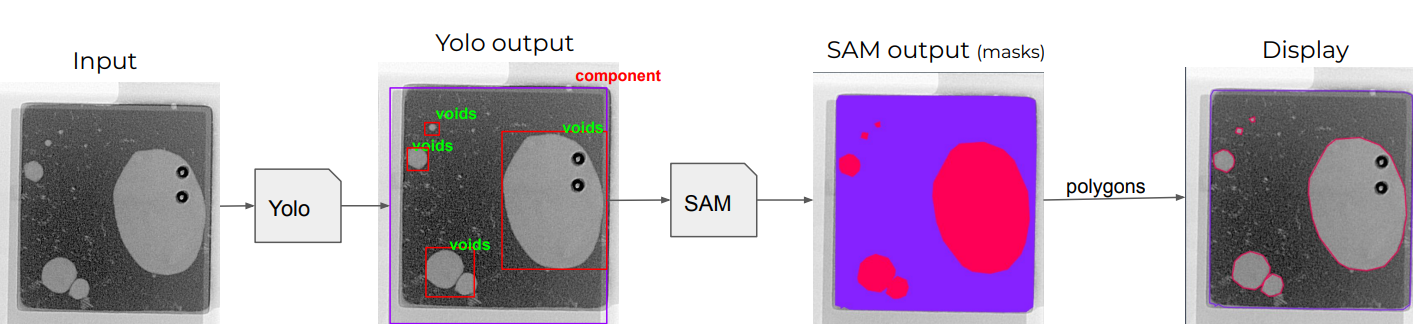

In [1]:
!nvidia-smi

Wed May 31 20:43:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import torch

HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8


In [3]:
!pip install ultralytics==8.0.20 --quiet

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 üöÄ Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ‚úÖ (2 CPUs, 12.7 GB RAM, 23.3/166.8 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## Download the Dataset

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="Hp5hidJ2MxhXMd3IYOmb")
project = rf.workspace("samdeploymentmodel").project("pcb_quality_control")
dataset = project.version(1).download("yolov8")

/content/datasets
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56.3/56.3 kB 2.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54.5/54.5 kB 6.9 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to PCB_Quality_Control-1 in yolov8:: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 94/94 [00:00<00:00, 1567.95it/s]


## üêç Download and use the Yolov8 model we trained in the previous step


In [6]:
!wget -O /content/yolov8_pcb_best.pt "https://raw.githubusercontent.com/ajosegun/PCBQualityControl/main/yolov8_pcb_best.pt"


--2023-05-31 20:44:09--  https://raw.githubusercontent.com/ajosegun/PCBQualityControl/main/yolov8_pcb_best.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22538616 (21M) [application/octet-stream]
Saving to: ‚Äò/content/yolov8_pcb_best.pt‚Äô

/content/yolov8_pcb 100%[===================>]  21.49M  91.5MB/s    in 0.2s    

2023-05-31 20:44:10 (91.5 MB/s) - ‚Äò/content/yolov8_pcb_best.pt‚Äô saved [22538616/22538616]



In [ ]:
# import requests
# custom_yolo8n_url = "https://raw.githubusercontent.com/ajosegun/PCBQualityControl/main/yolov8_pcb_best.pt"

# try:
#     response = requests.get(custom_yolo8n_url)
#     response.raise_for_status()
    
#     with open(f"{HOME}/yolov8_pcb_best.pt", "wb") as file:
#         file.write(response.content)
        
#     print("File downloaded successfully!")
# except requests.exceptions.RequestException as e:
#     print(f"An error occurred while downloading the file: {e}")

File downloaded successfully!


### Test the model

In [7]:
%cd {HOME}
model_name_path = "yolov8_pcb_best.pt"
model = YOLO(model_name_path)
results = model.predict(source=f'{dataset.location}/test/images/02_JPG.rf.3dedd37c111d456d0f55255fc0577d71.jpg', 
                        conf=0.25, save=True)


/content


Ultralytics YOLOv8.0.20 üöÄ Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
Results saved to runs/detect/predict


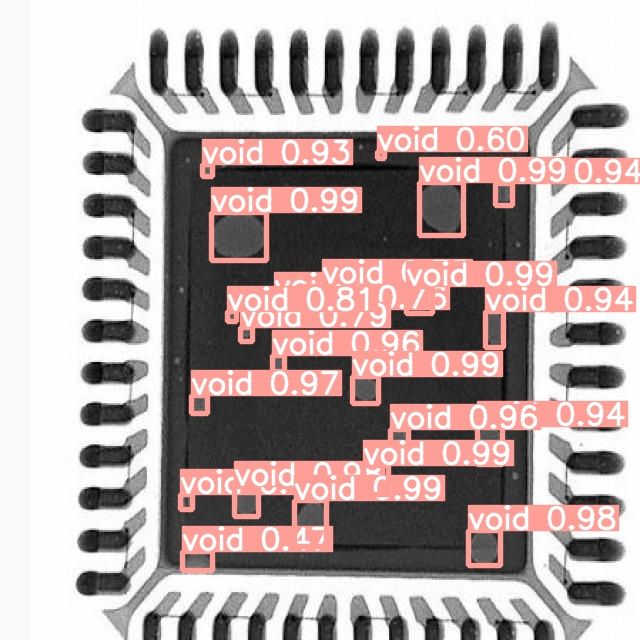

In [8]:
Image(filename=f'runs/detect/predict/02_JPG.rf.3dedd37c111d456d0f55255fc0577d71.jpg', height=600)

In [ ]:
# %cd {HOME}
# !yolo task=detect mode=predict model=yolov8_pcb_best.pt conf=0.25 source=datasets/PCB_Quality_Control-1/test/images save=True

## SAM

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The SamPredictor class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the set_image method, which calculates the necessary image embeddings. 

Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9r84v_3c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9r84v_3c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=b22525be65480af1b1183f92ebda63f7a2e69bfb71464e1dea1f4f0a2e11659a
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0al78zi/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [10]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx --quiet

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5.9/5.9 MB 49.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14.6/14.6 MB 89.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


### Selecting objects with SAM

First, load the SAM model and predictor. 

Running on CUDA and using the default model are recommended for best results.

In [11]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

In [12]:

import requests

model_type = "vit_h"
model_checkpoints_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

SAM_weights_path = "SAM_weights"

if not os.path.exists(SAM_weights_path):
  os.mkdir(SAM_weights_path)

sam_checkpoint_path = f"./{SAM_weights_path}/sam_vit_h_4b8939.pth" 

try:
    response = requests.get(model_checkpoints_url)
    response.raise_for_status()
    
    with open(sam_checkpoint_path, "wb") as file:
        file.write(response.content)
        
    print(f"SAM {model_type} model downloaded successfully!")
except requests.exceptions.RequestException as e:
    print(f"An error occurred while downloading the file: {e}")





SAM vit_h model downloaded successfully!


In [13]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint_path)
device = "cuda"
sam.to(device=device)
predictor = SamPredictor(sam)

https://docs.ultralytics.com/models/sam/#generate-segmentation-dataset-using-a-detection-model

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Defining helpful functions

In [15]:
def show_mask(mask, ax, cls=1, random_color=False):
    if random_color:
      color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
      if cls == 1: ## color for voids
        color = np.array([30/255, 144/255, 255/255, 0.7])
      else:
        color = np.array([255/255, 0.0, 0.0, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image
  

Process the image to produce an image embedding by calling SamPredictor.set_image. SamPredictor remembers this embedding and will use it for subsequent mask prediction.

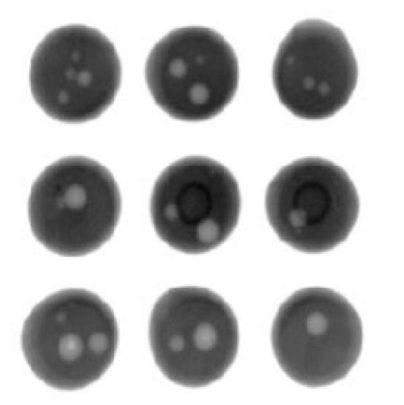

In [16]:
image_path = f'{dataset.location}/test/images/08_JPG.rf.6177acf9ba55c7969ef63686dc2c20e3.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

predictor.set_image(image)


In [17]:
# /content/datasets/PCB_Quality_Control-1/test/images/12_jpg.rf.2a979b4befa05fd24f4d3a7f342d2e33.jpg

image_path2 = f'{dataset.location}/test/images/12_jpg.rf.2a979b4befa05fd24f4d3a7f342d2e33.jpg'

image2 = cv2.imread(image_path2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(image2)
plt.axis('off')
plt.show()

predictor.set_image(image2)

In [18]:
image2.shape

(640, 640, 3)

In [19]:
image.shape

(640, 640, 3)

In [20]:
results_for_sam = model.predict(source=image_path, conf=0.25, save=True)

Results saved to runs/detect/predict


In [21]:
import glob
imgs=glob.glob(f"{dataset.location}/test/images/*") #
imgs

['/content/datasets/PCB_Quality_Control-1/test/images/10_JPG.rf.c9683e5fd9d440c629903bd0b1e6ac95.jpg',
 '/content/datasets/PCB_Quality_Control-1/test/images/18_jpg.rf.7e8270cd8819caca40b8f5506fd2dcd1.jpg',
 '/content/datasets/PCB_Quality_Control-1/test/images/02_JPG.rf.3dedd37c111d456d0f55255fc0577d71.jpg',
 '/content/datasets/PCB_Quality_Control-1/test/images/12_jpg.rf.2a979b4befa05fd24f4d3a7f342d2e33.jpg',
 '/content/datasets/PCB_Quality_Control-1/test/images/25_jpg.rf.1d131eea3614c28885524ea2f7d95b84.jpg',
 '/content/datasets/PCB_Quality_Control-1/test/images/08_JPG.rf.6177acf9ba55c7969ef63686dc2c20e3.jpg']

In [44]:
imgs[0]

'/content/datasets/PCB_Quality_Control-1/test/images/10_JPG.rf.c9683e5fd9d440c629903bd0b1e6ac95.jpg'

In [45]:
#transform all images into acceptable format
image_list=[]
for img in imgs:
  image = cv2.imread(img)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_list.append(image)

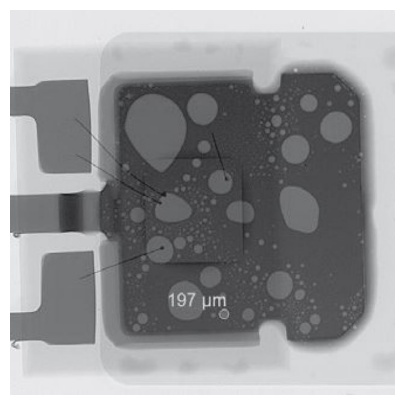

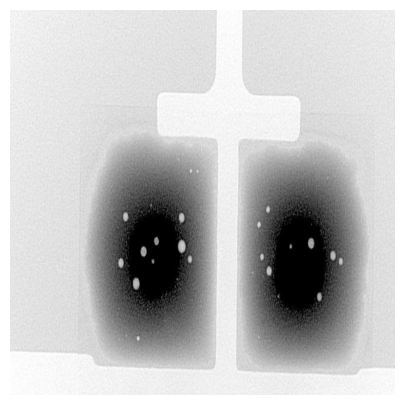

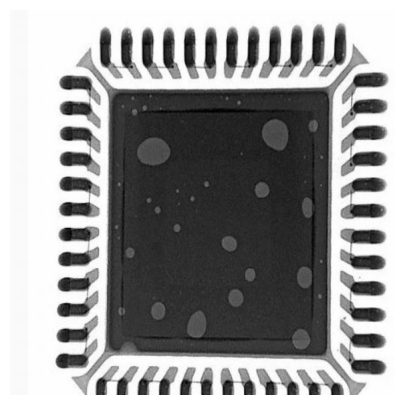

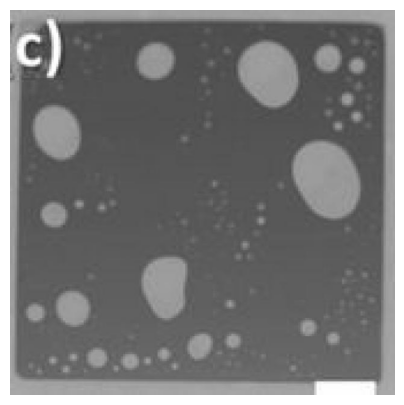

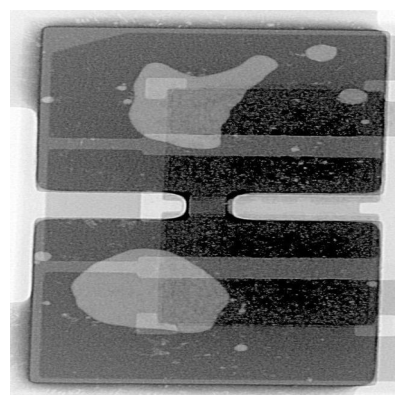

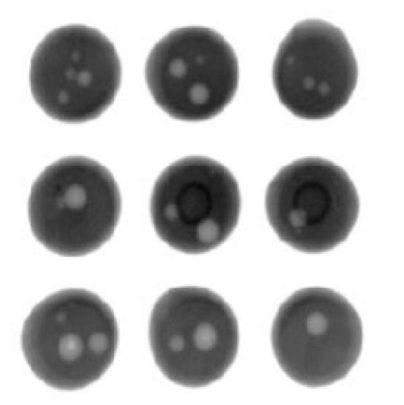

In [49]:
for image in image_list:
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  predictor.set_image(image)

In [34]:
#carryout the predictions on every test image
results_list=[]
for img in imgs:
  results_for_sam = model.predict(source=img, conf=0.25, save=True)
  results_list.append(results_for_sam)

Results saved to runs/detect/predict
Results saved to runs/detect/predict
Results saved to runs/detect/predict
Results saved to runs/detect/predict
Results saved to runs/detect/predict
Results saved to runs/detect/predict


In [35]:
len(results_list)

6

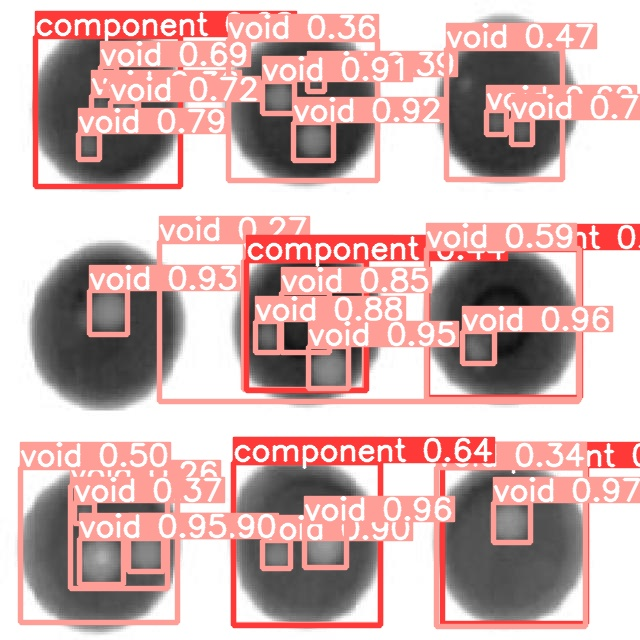

In [23]:
Image(filename=f'runs/detect/predict/08_JPG.rf.6177acf9ba55c7969ef63686dc2c20e3.jpg', height=300)

### Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using predict_torch method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [99]:
input_box = results_list[1][0].boxes.xyxy.cpu().data.numpy()
class_p = results_list[1][0].boxes.cls.cpu().data.numpy()

input_boxes = torch.tensor(input_box, device=predictor.device)

# # input_box_sin = results_for_sam[0].boxes[0].xyxy.cpu().data.numpy()
# # results_for_sam[0].boxes.cls

# input_box
# # input_box_sin

Transform the boxes to the input frame, then predict masks. SamPredictor stores the necessary transform as the transform field for easy access.

In [100]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
masks.shape

torch.Size([19, 1, 640, 640])

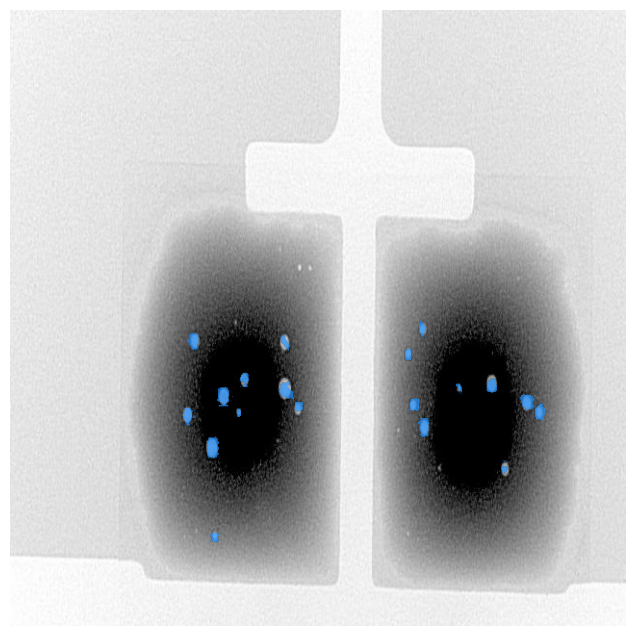

In [101]:
sorted_indices = np.argsort(class_p)

sorted_masks, sorted_class_p = masks[sorted_indices], class_p[sorted_indices]

plt.figure(figsize=(8, 8))
plt.imshow(image_list[1])
for mask, cls in zip(sorted_masks, sorted_class_p):
  show_mask(mask.cpu().numpy(), plt.gca(), cls=cls)

plt.axis('off')
plt.show()

Repeating the same process for all the test images

In [113]:
#save each image input transfoermed boxes
class_p_list=[]
transformed_boxes_list=[]
for result in results_list:
  input_box = result[0].boxes.xyxy.cpu().data.numpy()
  class_p = result[0].boxes.cls.cpu().data.numpy()
  input_boxes = torch.tensor(input_box, device=predictor.device)

  transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
  
  transformed_boxes_list.append(transformed_boxes)
  class_p_list.append(class_p)

#get mask from each transformed input box
masks_list=[]
for boxes in transformed_boxes_list:
  masks, _, _ = predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=boxes,
      multimask_output=False,
  )
  masks_list.append(masks)

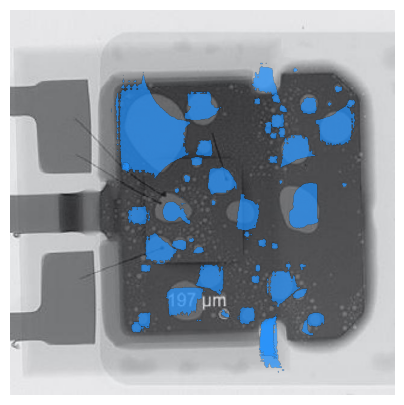

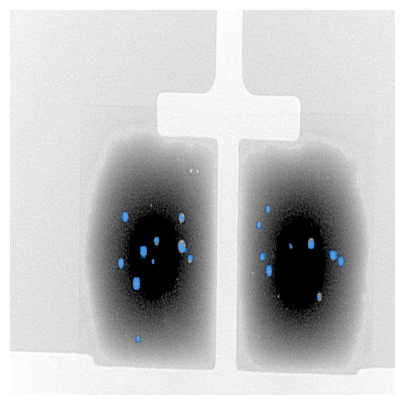

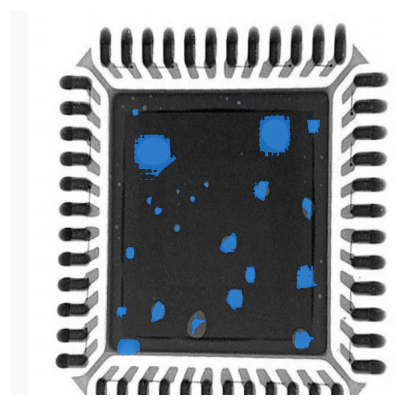

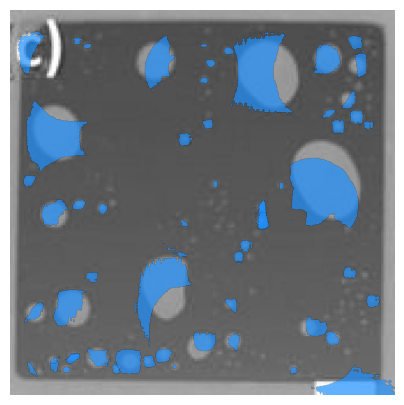

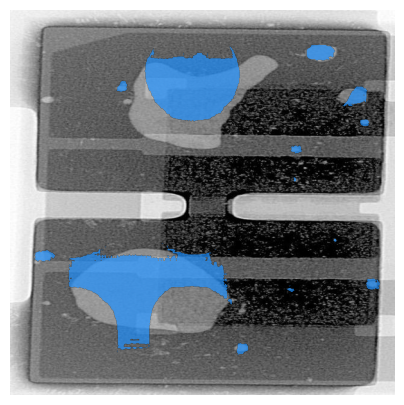

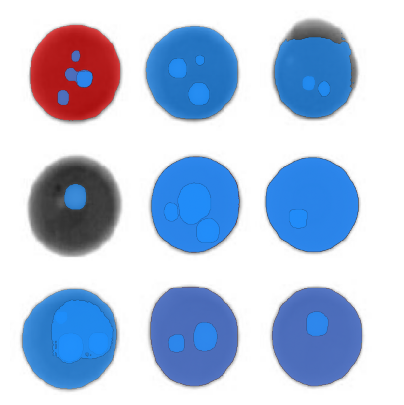

In [114]:
for mask, class_p, image in zip(masks_list, class_p_list, image_list):
  sorted_indices = np.argsort(class_p)
  sorted_masks, sorted_class_p = mask[sorted_indices], class_p[sorted_indices]

  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  for mask, cls in zip(sorted_masks, sorted_class_p):
    show_mask(mask.cpu().numpy(), plt.gca(), cls=cls)
  plt.axis('off')
  plt.show()

In [ ]:
# masks_sin, _, _ = predictor.predict(
#     point_coords=None,
#     point_labels=None,
#     box= input_box_sin[None, :],
#     multimask_output=False,
# )

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_mask(masks_sin[0], plt.gca())
# # show_box(input_box, plt.gca())
# plt.axis('off')
# plt.show()

In [52]:
def polygon_area(polygon):
    num_points = len(polygon)
    signed_area = 0

    for i in range(num_points):
        x_i, y_i = polygon[i]
        x_next, y_next = polygon[(i + 1) % num_points]
        signed_area += x_i * y_next - x_next * y_i

    return abs(signed_area) / 2

### Calculate the area of each mask from SAM polygon points
‚óã Components areas

‚óã Void areas

‚óã ‚áí calculate the rate of voids : r = component area / total voids areas within a components

‚òÖ Output to csv


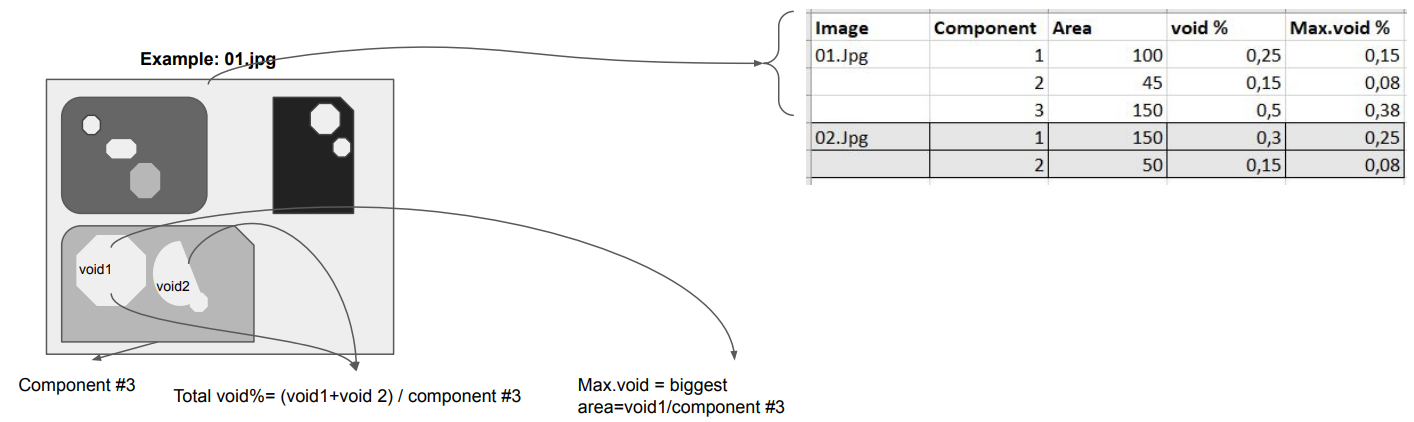

In [115]:
import pandas as pd

component_total_area_list=[]
void_total_area_list=[]
biggest_void_area_list=[]
void_percent_list=[]

for masks, class_p in zip(masks_list, class_p_list):
  component_total_area = 0
  void_total_area = 0
  biggest_void_area = 0
  for mask, cls in zip(masks, class_p):
    polygon = np.argwhere(mask.cpu().data.numpy())

    # Calculate the area
    area = polygon_area(polygon[:, 1:])

    if cls == 0: ## component
      component_total_area += area
    elif cls == 1: ## void
      void_total_area += area
      if area > biggest_void_area:
        biggest_void_area = area
    void_percent=void_total_area / component_total_area

  component_total_area_list.append(component_total_area)
  void_total_area_list.append(void_total_area)
  biggest_void_area_list.append(biggest_void_area)
 
  void_percent_list.append(void_percent)


# add these lists to a dataframe
img_names=[img_path.split("/")[-1] for img_path in imgs] #get only images names
df_final = pd.DataFrame(list(zip(img_names,component_total_area_list, void_total_area_list, biggest_void_area_list, void_percent_list)),
               columns =['Image', 'Component_total_area','void_total_area','Max.void','Void%'])

divide by zero encountered in double_scalars


In [116]:
df_final

Image  Component_total_area  \
0  10_JPG.rf.c9683e5fd9d440c629903bd0b1e6ac95.jpg                   0.0   
1  18_jpg.rf.7e8270cd8819caca40b8f5506fd2dcd1.jpg                   0.0   
2  02_JPG.rf.3dedd37c111d456d0f55255fc0577d71.jpg                   0.0   
3  12_jpg.rf.2a979b4befa05fd24f4d3a7f342d2e33.jpg                   0.0   
4  25_jpg.rf.1d131eea3614c28885524ea2f7d95b84.jpg                   0.0   
5  08_JPG.rf.6177acf9ba55c7969ef63686dc2c20e3.jpg                2986.5   

   void_total_area  Max.void     Void%  
0           7518.0    1224.0       inf  
1            441.0      80.5       inf  
2           1999.5     685.0       inf  
3          12968.5    4742.0       inf  
4          13487.5    9023.0       inf  
5          24555.0   15611.5  8.221999

In [117]:
component_total_area = 0
void_total_area = 0
biggest_void_area = 0

for mask, cls in zip(masks, class_p):
  polygon = np.argwhere(mask.cpu().data.numpy())

  # Calculate the area
  area = polygon_area(polygon[:, 1:])

  if cls == 0: ## component
    component_total_area += area
  elif cls == 1: ## void
    void_total_area += area
    if area > biggest_void_area:
      biggest_void_area = area

print(f'Component_total_area: {component_total_area}')
print(f'void_total_area: {void_total_area}')

print(f'biggest_void_area: {biggest_void_area}')
print(f'Total void%: {void_total_area / component_total_area}')

data = {
    'Image': [imgs[0].split("/")[-1]],
    'Component_total_area': [component_total_area],
    'void_total_area': [void_total_area],
    'Max.void': [biggest_void_area],
    'Void%': [void_total_area / component_total_area]
}

df = pd.DataFrame(data)
df.head()

Component_total_area: 2986.5
void_total_area: 24555.0
biggest_void_area: 15611.5
Total void%: 8.221998995479659


Image  Component_total_area  \
0  10_JPG.rf.c9683e5fd9d440c629903bd0b1e6ac95.jpg                2986.5   

   void_total_area  Max.void     Void%  
0          24555.0   15611.5  8.221999